In [1]:
import hdcms as hdc
from IPython.display import Image
import re
import random
import numpy as np
np.set_printoptions(precision=3, linewidth=99999999999)
random.seed(420)

%load_ext line_profiler

```
+-----------------------------------------------------+
|                 180 replicates                      |
+-----------------+-----------------+-----------------+
|     60 reps     |     60 reps     |     60 reps     |
|      Meta       |     Ortho       |       Para      |
+-----------------+-----------------+-----------------+
|A |B |C |D |E |F |A |B |C |D |E |F |A |B |C |D |E |F |
|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|10|
+-----------------------------------------------------+
```

this is the layout of the data

In [30]:
DATA = "/Users/jason/.root/time/sem06/nist/WVU/FF_me/"
compounds = ["Meta", "Ortho", "Para"]
labs = ["A", "B", "C", "D", "E", "F"]
def f2stats(arg):
#     sum_stat = hdc.filenames2stats2d(arg)
#     return sum_stat[sum_stat[:,1] != 0]
    return hdc.filenames2stats1d(arg)

before
after


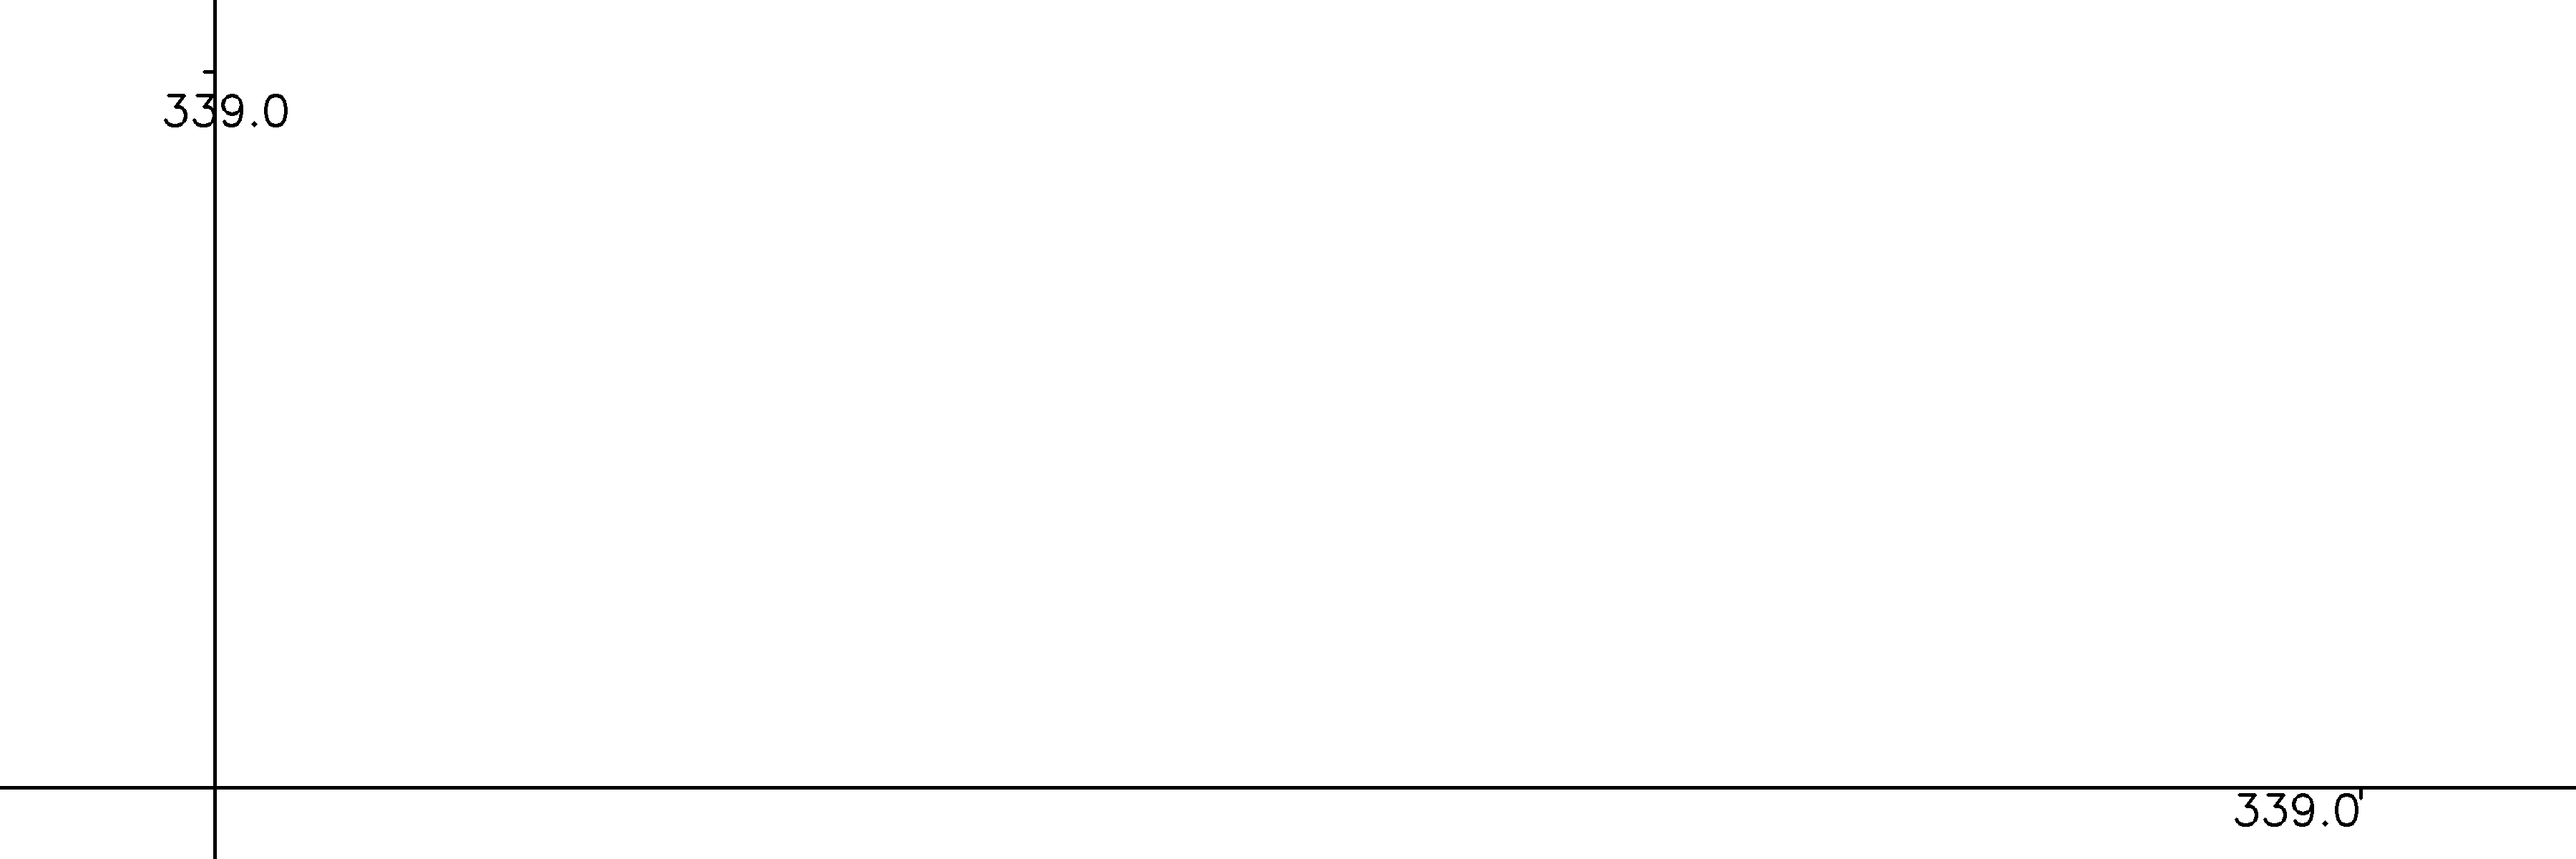

In [55]:
lab_b_meta = hdc.regex2stats2d(r"B_Meta-\d[AB].txt", dir=DATA)
# remove 0 peaks (since her data is weird)
lab_b_meta = lab_b_meta[lab_b_meta[:,1] != 0]
hdc.write_image(lab_b_meta, "../images/lab_b_meta.png")
Image(filename="../images/lab_b_meta.png")

In [4]:
# helper functions

def rand_sel(input, div=-1):
    """div=-1 means half in this case"""
    l = input.copy()
    if div == -1:
        div = len(l)//2
    random.shuffle(l)
    return l[:div], l[div:]

def get_filenames(compound, lab, dir=DATA):
    """ex: get_filenames("Meta", "A")
    this would get all replicates from lab A, for Meta-FF
    
    get_filenames("Ortho", ".")
    this would take a random 5 replicates from all labs for Ortho-FF
    """
    files = [f for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    r = re.compile(lab + "_" + compound + r"-\d[AB].txt")
    matches = []
    for f in files:
        match = r.match(f)
        if match:
            matches.append(f)
    
    if len(matches) == 0:
        raise RuntimeError(f"No matches for {regex} in directory {dir}")
    final = list(map(lambda f: os.path.join(dir, f), matches))
    return final

def remove_diag(input):
    mat = np.copy(input)
    assert(mat.shape[0] == mat.shape[1])
    for i in range(mat.shape[0]):
        mat[i,i] = 0
    return mat

In [62]:
bad_count = 0
total = 0

print("PER LAB 10 SAMPLES VS N-10 SAMPLES (excluding lab)")
print(f"compounds: {compounds}")
for compound in compounds:
    for lab in labs:
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        
        compounds_excluding_lab = []
        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            sel, _ = rand_sel(new_list, div=10)
            assert(len(sel) == 10)
            reps = ','.join(sel)
            compounds_excluding_lab.append(f2stats(reps))
        mat = hdc.compare(lab_stat, *compounds_excluding_lab)
        most_sim = np.argmax(remove_diag(mat),axis=1)[0] # this gets argmax of first row
        goal_ind = compounds.index(compound)+1
        
        print(f"lab: {lab}, compound: {compound}", end=" ")
        total += 1
        if goal_ind != most_sim:
            bad_count += 1
            print("HELP:", mat[0,1:])
        else:
            print("GOOD!", mat[0,1:])

print(bad_count, '/', total, '=', f"{str(100 - bad_count/total * 100)[:4]}%")

PER LAB 10 SAMPLES VS N-10 SAMPLES (excluding lab)
compounds: ['Meta', 'Ortho', 'Para']
lab: A, compound: Meta HELP: [0.959 0.848 0.962]
lab: B, compound: Meta HELP: [0.926 0.855 0.937]
lab: C, compound: Meta HELP: [0.796 0.845 0.845]
lab: D, compound: Meta GOOD! [0.968 0.854 0.957]
lab: E, compound: Meta GOOD! [0.965 0.813 0.955]
lab: F, compound: Meta GOOD! [0.868 0.761 0.849]
lab: A, compound: Ortho GOOD! [0.889 0.915 0.903]
lab: B, compound: Ortho HELP: [0.937 0.874 0.961]
lab: C, compound: Ortho GOOD! [0.743 0.811 0.787]
lab: D, compound: Ortho GOOD! [0.741 0.823 0.759]
lab: E, compound: Ortho HELP: [0.888 0.949 0.955]
lab: F, compound: Ortho GOOD! [0.748 0.841 0.74 ]
lab: A, compound: Para HELP: [0.878 0.769 0.858]
lab: B, compound: Para GOOD! [0.951 0.874 0.952]
lab: C, compound: Para HELP: [0.917 0.936 0.913]
lab: D, compound: Para GOOD! [0.927 0.924 0.978]
lab: E, compound: Para HELP: [0.95  0.846 0.943]
lab: F, compound: Para GOOD! [0.877 0.874 0.882]
8 / 18 = 55.5%


In [49]:
def perlab10():
    print("PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)")
    bad_count = 0
    total = 0

    print(f"compounds: {compounds}")
    for compound in compounds:
        for lab in labs:
            lab_list = get_filenames(compound, lab)
            assert(len(lab_list) == 10)
            lab_reps = ','.join(lab_list)
            lab_stat = f2stats(lab_reps)

            compounds_excluding_lab = []
            for new_compound in compounds:
                if compound == new_compound:
                    new_lab = "[^"+lab+"]" # not our lab
                else:
                    new_lab = "." # anything
                new_list = get_filenames(new_compound, new_lab)
                assert(len(new_list) == 50 or len(new_list) == 60)
                if compound == new_compound:
                    sel = new_list
                else:
                    # drop 10 reps if another comound so everything has 50 (so we don't bias toward/away from original compound)
                    _, sel = rand_sel(new_list, div=10)
                assert(len(sel) == 50)
                reps = ','.join(sel)
                compounds_excluding_lab.append(f2stats(reps))
            mat = hdc.compare(lab_stat, *compounds_excluding_lab)
            most_sim = np.argmax(remove_diag(mat),axis=1)[0] # this gets argmax of first row
            goal_ind = compounds.index(compound)+1

            print(f"lab: {lab}, compound: {compound}", end=" ")
            total += 1
            if goal_ind != most_sim:
                bad_count += 1
                print("HELP:", mat[0,1:])
            else:
                print("GOOD!", mat[0,1:])

    print(bad_count, '/', total, '=', f"{str(100 - bad_count/total * 100)[:4]}%")
# %lprun -f perlab10 perlab10()
perlab10()

PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)
compounds: ['Meta', 'Ortho', 'Para']
lab: A, compound: Meta GOOD! [0.946 0.823 0.936]
lab: B, compound: Meta GOOD! [0.954 0.834 0.953]
lab: C, compound: Meta HELP: [0.79  0.843 0.836]
lab: D, compound: Meta GOOD! [0.965 0.876 0.956]
lab: E, compound: Meta GOOD! [0.959 0.814 0.948]
lab: F, compound: Meta GOOD! [0.863 0.813 0.84 ]
lab: A, compound: Ortho HELP: [0.88  0.875 0.906]
lab: B, compound: Ortho HELP: [0.933 0.908 0.961]
lab: C, compound: Ortho GOOD! [0.745 0.837 0.749]
lab: D, compound: Ortho GOOD! [0.754 0.83  0.742]
lab: E, compound: Ortho GOOD! [0.909 0.942 0.94 ]
lab: F, compound: Ortho GOOD! [0.743 0.836 0.769]
lab: A, compound: Para HELP: [0.889 0.78  0.867]
lab: B, compound: Para GOOD! [0.95  0.848 0.968]
lab: C, compound: Para HELP: [0.898 0.921 0.908]
lab: D, compound: Para GOOD! [0.915 0.909 0.949]
lab: E, compound: Para GOOD! [0.958 0.839 0.96 ]
lab: F, compound: Para HELP: [0.897 0.866 0.887]
6 / 18 = 66.6%


In [60]:
# all this cell does is count replicates
print("COUNT REPS: PER LAB 10 SAMPLES VS ALL-10 SAMPLES (excluding lab)")
# print(f"compounds: {compounds}")
lib_num_reps = []
query_num_reps = []
for compound in compounds:
    for lab in labs:
#         print(f"compound: {compound}, lab: {lab}")
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        query_num_reps.append(np.count_nonzero(lab_stat[:, 0]))
        
        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            sel, _ = rand_sel(new_list, div=10)
            assert(len(sel) == 10)
            reps = ','.join(sel)
            sum_stat = f2stats(reps)
            lib_num_reps.append(np.count_nonzero(sum_stat[:, 0]))

print(np.mean(np.array(lib_num_reps)))
print(np.mean(np.array(query_num_reps)))

COUNT REPS: PER LAB 10 SAMPLES VS ALL-10 SAMPLES (excluding lab)
223.9814814814815
205.66666666666666


In [61]:
# all this cell does is count replicates
print("PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)")
# print(f"compounds: {compounds}")
lib_num_reps = []
query_num_reps = []
for compound in compounds:
    for lab in labs:
#         print(f"compound: {compound}, lab: {lab}")
        lab_list = get_filenames(compound, lab)
        assert(len(lab_list) == 10)
        lab_reps = ','.join(lab_list)
        lab_stat = f2stats(lab_reps)
        query_num_reps.append(np.count_nonzero(lab_stat[:, 0]))

        for new_compound in compounds:
            if compound == new_compound:
                new_lab = "[^"+lab+"]" # not our lab
            else:
                new_lab = "." # anything
            new_list = get_filenames(new_compound, new_lab)
            assert(len(new_list) == 50 or len(new_list) == 60)
            if compound == new_compound:
                sel = new_list
            else:
                # drop 10 reps if another comound so everything has 50 (so we don't bias toward/away from original compound)
                _, sel = rand_sel(new_list, div=10)
            assert(len(sel) == 50)
            reps = ','.join(sel)
            sum_stat = f2stats(reps)
            lib_num_reps.append(np.count_nonzero(sum_stat[:, 0]))
            
print(np.mean(np.array(lib_num_reps)))
print(np.mean(np.array(query_num_reps)))

PER LAB 10 SAMPLES VS 10 SAMPLES (excluding lab)
240.40740740740742
205.66666666666666
